### TPM HISTOGRAM

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os, glob, sys, pickle
import matplotlib.patches as mpatches
from scipy.stats import ks_2samp

In [2]:
from matplotlib.patches import Patch

In [3]:
f = open('TPM_data.pickle','rb')
tpm = pickle.load(f)

In [139]:
med = []
for ops in tpm.index:
    m, b=np.histogram(tpm[ops][np.isfinite(tpm[ops])], bins=np.linspace(0,0.5,100))
    med.append(m)
med = np.median(med,axis=0)
med = np.append(med,[0])

In [160]:
ks= np.empty_like(tpm.index)
for i, ops in enumerate(tpm.index):
    m, b=np.histogram(tpm[ops][np.isfinite(tpm[ops])], bins=np.linspace(0,0.5,100))
    ks[i]=(ks_2samp(m,med).statistic)

In [169]:
tpm.index[np.where(ks>0.15)]

Index(['footprint_stuck_rollingv1.5_10yrs', 'footprint_big_wfdv1.5_10yrs',
       'twilight_neo_mod1_v1.5_10yrs', 'twilight_neo_mod3_v1.5_10yrs',
       'twilight_neo_mod2_v1.5_10yrs'],
      dtype='object')

(-0.001, 0.5)

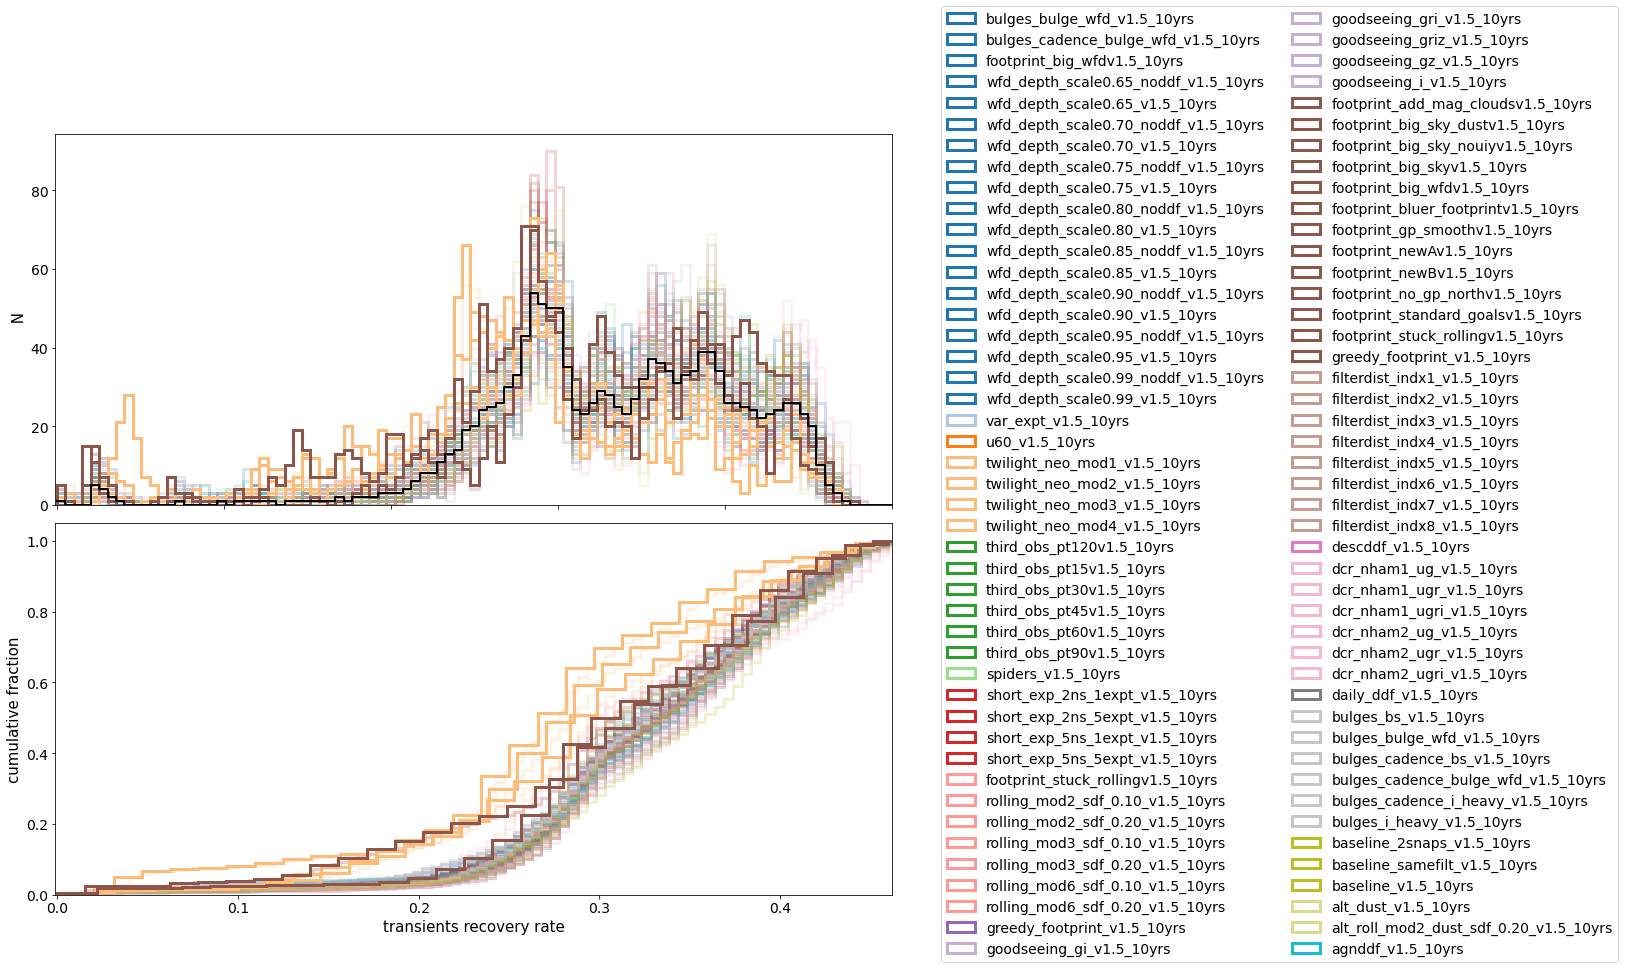

In [170]:
cm = np.concatenate([plt.get_cmap('tab20').colors,plt.get_cmap('Set3').colors])
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
fig, ax = plt.subplots(2,1,figsize=(15,14))
patches=[]
n=1
cmap =[]
legend_elements = []
#lista=['baseline_v1.5_10yrs','footprint_newBv1.5_10yrs','wfd_depth_scale0.99_v1.5_10yrs','rolling_mod3_sdf_0.10_v1.5_10yrs','short_exp_5ns_1expt_v1.5_10yrs']
lista=['footprint_stuck_rollingv1.5_10yrs', 'footprint_big_wfdv1.5_10yrs',
       'twilight_neo_mod1_v1.5_10yrs', 'twilight_neo_mod3_v1.5_10yrs',
       'twilight_neo_mod2_v1.5_10yrs']
ax[0].step(b,med,where='post',color='k',linewidth=2,zorder=100)
for f,c in zip(np.unique(family)[::-1],cm[0:len(family)]):
    for ops in np.sort(tpm.index):        
        if f in ops:
            a = 0.2
            if ops in lista:
                ax[0].hist(tpm[ops][np.isfinite(tpm[ops])], bins=np.linspace(0,0.5,100), cumulative=False,density=False, histtype='step', alpha=1,color=c,lw=3,zorder=50)
                ax[0].set_xticklabels([])
                ax[1].hist(tpm[ops][np.isfinite(tpm[ops])], bins=30, cumulative=True,density=True, histtype='step', alpha=1,color=c,lw=3,zorder=50)
            cmap.append(matplotlib.colors.rgb2hex(c))
            legend_elements.append(Patch(facecolor='white', edgecolor=c,label=ops, linewidth=3))
            ax[1].hist(tpm[ops][np.isfinite(tpm[ops])], bins=np.linspace(0,0.5,100), cumulative=True,density=True, histtype='step', alpha=a,color=c,lw=3)
            ax[0].hist(tpm[ops][np.isfinite(tpm[ops])], bins=np.linspace(0,0.5,100), cumulative=False,density=False, histtype='step', alpha=a,color=c,lw=3)
            ax[0].set_xticklabels([])
            #patches.append(mpatches.Patch(color=c, label=ops))
            ax[1].set_xlabel('transients recovery rate', fontsize=15)
            ax[1].set_ylabel('cumulative fraction', fontsize=15)
            ax[0].set_ylabel(' N', fontsize=15)
            
ax[1].legend(handles=legend_elements,ncol=2,bbox_to_anchor=(1.05,-0.2), loc='lower left',fontsize=14)
plt.subplots_adjust(hspace=0.05)   #legl = leg.get_lines()(-0.02, -2.92)
ax[1].set_xlim([-0.001,0.462])
ax[0].set_xlim([-0.001,0.5])

### BAR PLOT

In [7]:
dbpath_v1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v1_7 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"  # path to all opsim databases

In [8]:
# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath_v1_5)  # change to opsim database directory
dblist_all_v1_5 = glob.glob('*.db') 
dblist_all_v1_5.sort()

os.chdir(dbpath_v1_7)  # change to opsim database directory
dblist_all_v1_7 = glob.glob('*.db') 
dblist_all_v1_7.sort()

os.chdir(workpath) # change back to work directory

In [6]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"

In [3]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]

In [4]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5", "") )
    
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("10yrs", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new

In [5]:
def get_mycmap():
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    cm = plt.get_cmap('tab10')

    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    

    
    colors = np.array( [cm.colors[3],cm.colors[1],cm.colors[0],cm.colors[6]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap

In [6]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", invertx=False, ytickpos='left', title='',dbtoarrow=[] ,**kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_max_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_max_family, on='family', how='left', suffixes=['', '_fmax'],)
    
    # get the mean FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).mean()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'])
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmax', 'total_fmean', 'total' ], ascending=[True, True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    if dbtoarrow:
        for d in dbtoarrow:
            idx = np.where(df_.index==d)
            if not invertx:
                xin,xfin=1.5,1.6
            else:
                xin,xfin=-0.5,-0.6
            ax.annotate('', xy=(xin,idx[0]/len(df_.index)+0.005), xytext=(xfin, idx[0]/len(df_.index)+0.005), xycoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05))
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
        
    if invertx:
        ax.invert_xaxis()
        #ax.yaxis.tick_right()
        plt.legend(loc='lower left', frameon=True)
    
    ax.yaxis.tick_right() if ytickpos=='right' else ax.yaxis.tick_left()

    # modify labels
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        #if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
            #tl.set_fontweight('bold') 
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    
        #tl.set_text(txt)
    #

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    return ax

In [9]:
df_r_all = pd.read_csv('df_radar_allversion.csv')
idx_all15 = [] 
idx_all17 = []
for i, ops in enumerate(list(df_r_all['db'])):
    l = ops.split('_')
    if 'v1.5' in l:
        idx_all15.append(i)
    if 'v1.7' in l:
        idx_all17.append(i)
    if 'v1.710yrs.db' in l:
        idx_all17.append(i)
    if 'gcbv1.7' in l:
        idx_all17.append(i)
    if 'gl30v1.7' in l:
        idx_all17.append(i)
    if 'gl200v1.7' in l:
        idx_all17.append(i)
    if 'gl100v1.7' in l:
        idx_all17.append(i)
idx_all15=np.array(idx_all15)
idx_all17=np.array(idx_all17)

['agnddf', 'v1.5', '10yrs.db']
['alt', 'dust', 'v1.5', '10yrs.db']
['alt', 'roll', 'mod2', 'dust', 'sdf', '0.20', 'v1.5', '10yrs.db']
['baseline', '2snaps', 'v1.5', '10yrs.db']
['baseline', 'samefilt', 'v1.5', '10yrs.db']
['baseline', 'v1.5', '10yrs.db']
['bulges', 'bs', 'v1.5', '10yrs.db']
['bulges', 'bulge', 'wfd', 'v1.5', '10yrs.db']
['bulges', 'cadence', 'bs', 'v1.5', '10yrs.db']
['bulges', 'cadence', 'bulge', 'wfd', 'v1.5', '10yrs.db']
['bulges', 'cadence', 'i', 'heavy', 'v1.5', '10yrs.db']
['bulges', 'i', 'heavy', 'v1.5', '10yrs.db']
['daily', 'ddf', 'v1.5', '10yrs.db']
['dcr', 'nham1', 'ug', 'v1.5', '10yrs.db']
['dcr', 'nham1', 'ugr', 'v1.5', '10yrs.db']
['dcr', 'nham1', 'ugri', 'v1.5', '10yrs.db']
['dcr', 'nham2', 'ug', 'v1.5', '10yrs.db']
['dcr', 'nham2', 'ugr', 'v1.5', '10yrs.db']
['dcr', 'nham2', 'ugri', 'v1.5', '10yrs.db']
['descddf', 'v1.5', '10yrs.db']
['filterdist', 'indx1', 'v1.5', '10yrs.db']
['filterdist', 'indx2', 'v1.5', '10yrs.db']
['filterdist', 'indx3', 'v1.5', '

In [10]:
dblist_all = dblist_all_v1_5
df_norm_15 = get_df_norm(fomcsv = 'Score_foms_v1.5_2yrs.csv', cols=['TPM','LS','CI'], mode=0)


In [11]:
dblist_all = dblist_all_v1_7
df_norm_17 = get_df_norm(fomcsv = 'Score_foms_v1.7_2yrs.csv', cols=['TPM','LS','CI'], mode=0)

In [12]:
df_norm_15['star count'] = df_r_all['star count'][idx_all15]

df_norm_17['star count'] = np.array(list(df_r_all['star count'][idx_all17]))

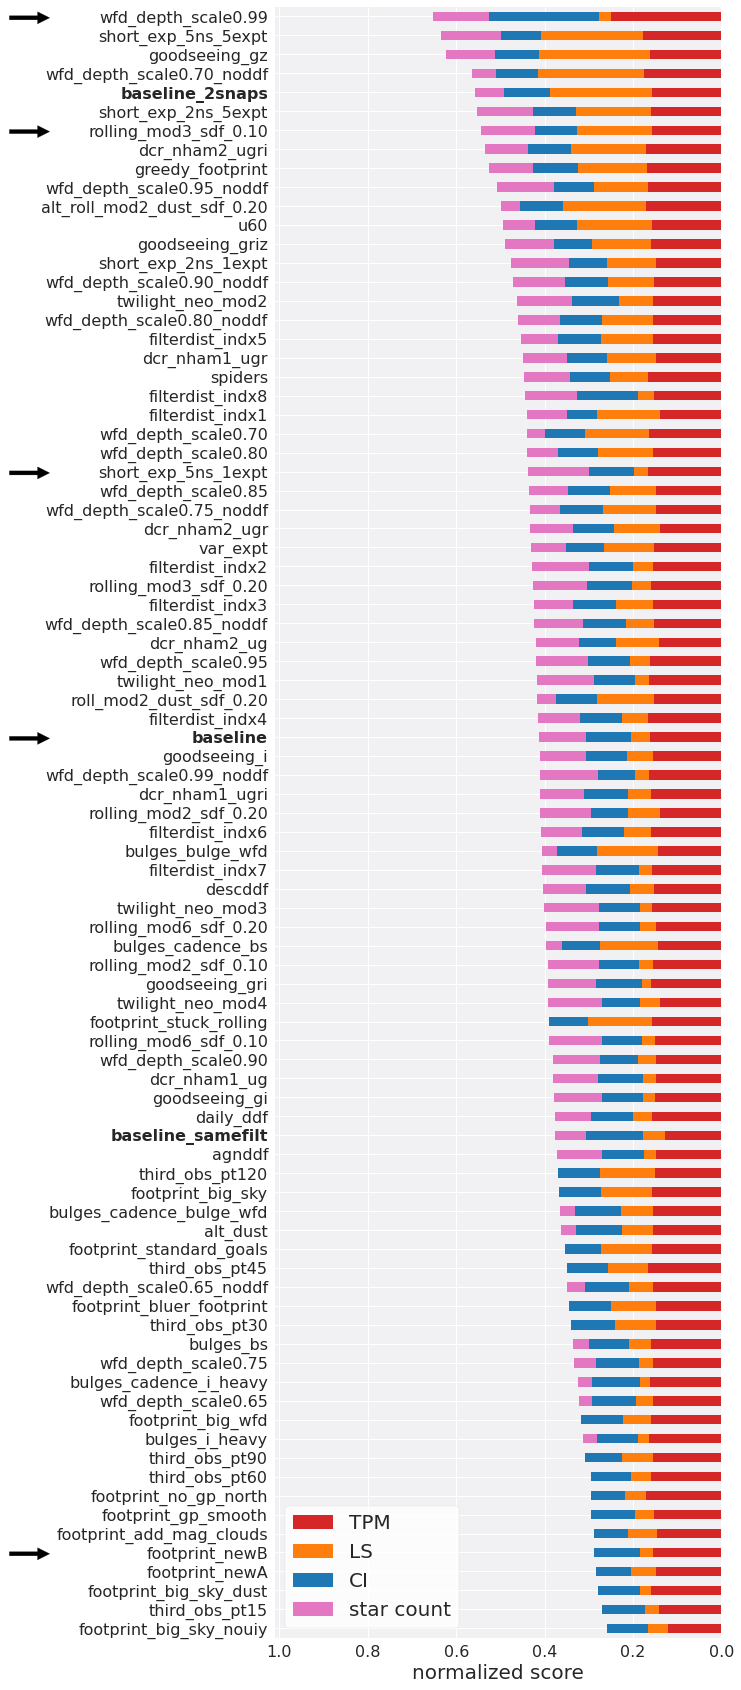

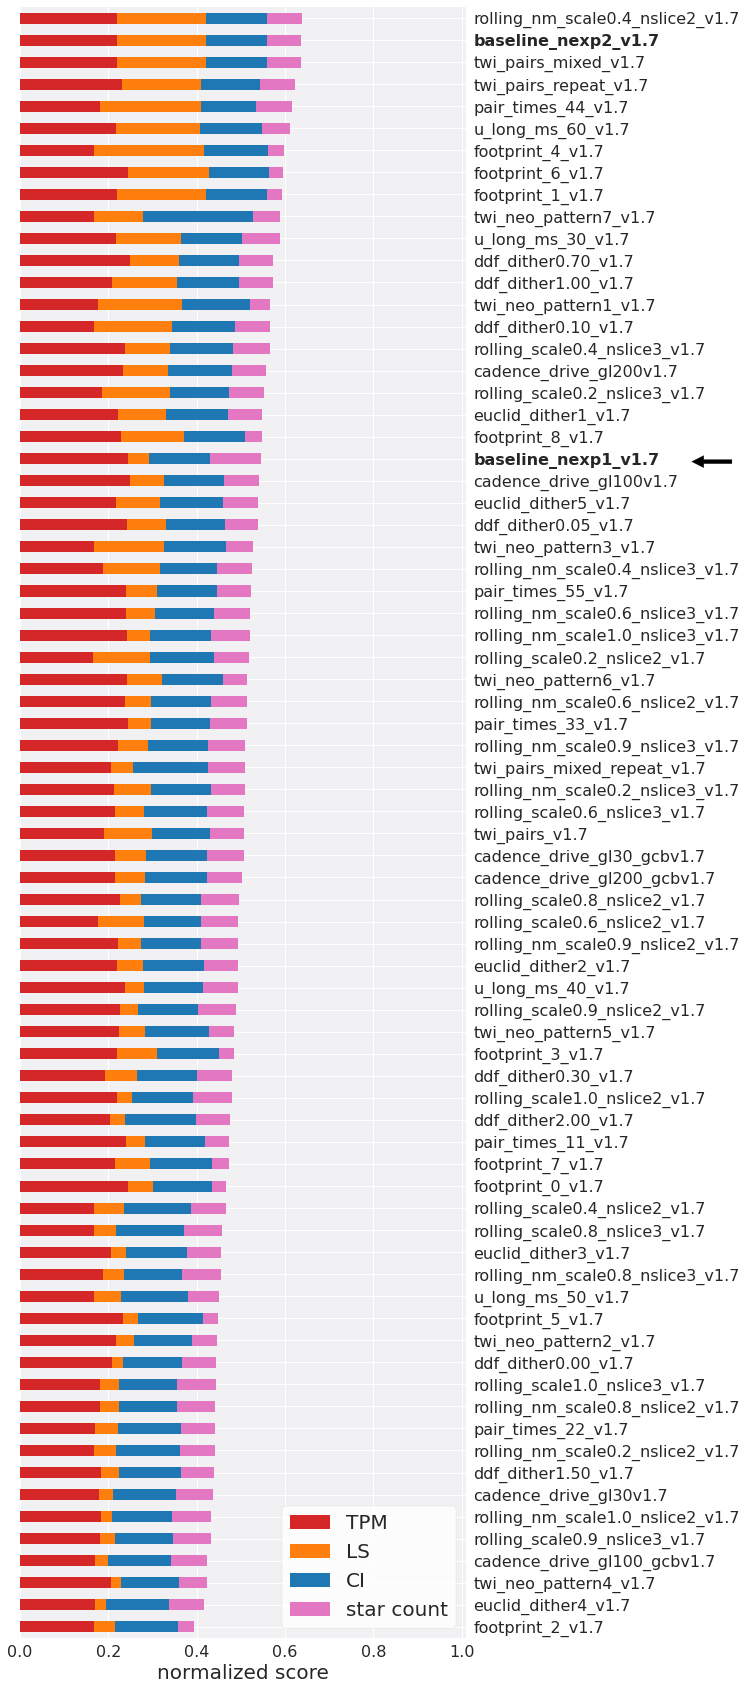

In [47]:
ax = plot_barh(df_norm_15, colon=['TPM','LS','CI','star count'], invertx=True,  byfamily=False, savefig='fom1p5_2yrs_invertx.pdf', dbtoarrow=[ 'baseline', 'footprint_newB',
           'wfd_depth_scale0.99','rolling_mod3_sdf_0.10',
           'short_exp_5ns_1expt'],colormap=get_mycmap()) 
ax = plot_barh(df_norm_17, colon=['TPM','LS','CI','star count'], invertx=False,ytickpos='right', byfamily=False, savefig='fom1p7_2yrs_Ninvertx.pdf', dbtoarrow=['baseline_nexp1_v1.7'],colormap=get_mycmap()) 

### RADAR PLOT

In [13]:
def plot_radar(r, ax=None, fill=True, figsize=(6,6), **kwargs):
    """plot a radar 
    Inputs: r, list like"""
    
    if ax==None:
        fig, ax = plt.subplots(1,1,figsize=figsize, subplot_kw={'projection': 'polar'} )
    
    r = list(r)
    N = len(r)
    r.append( r[0] )  # repeat first to close circle

    # get angle for each value
    theta = [n * 2 * np.pi / N  for n in range(N) ]
    theta.append( theta[0] )
    
    ax.plot(theta, r, **kwargs)
    if fill:
        ax.fill(theta, r, alpha=0.1)
    ax.set_xticks(theta[:-1], );
    #ax.set_xticklabels( ['v1', 'v2'] );
    ax.spines['polar'].set_visible(False)  
    return ax

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/projections/polar.py:48: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


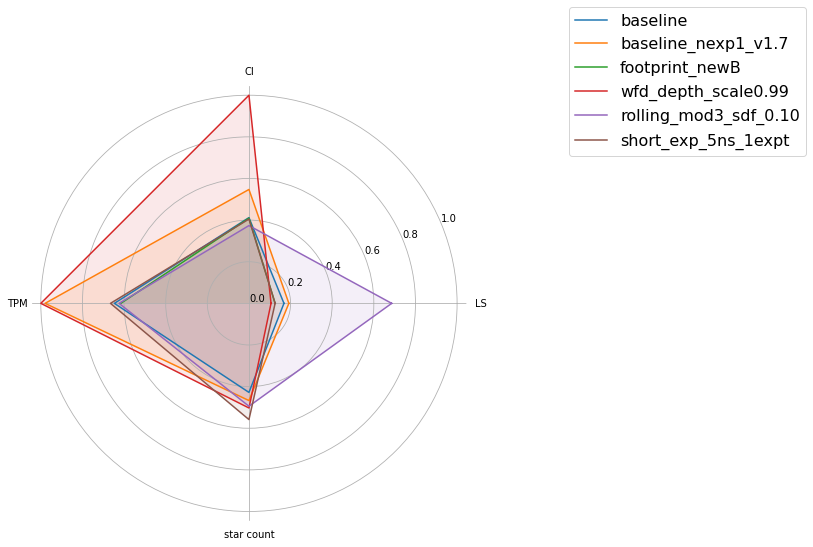

In [15]:
dbnames = [ 'baseline','baseline_nexp1_v1.7', 'footprint_newB',
           'wfd_depth_scale0.99','rolling_mod3_sdf_0.10',
           'short_exp_5ns_1expt']

FoMvars = ['LS', 'CI', 'TPM','star count']


fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection': 'polar'} )

for dbname in dbnames:
    if 'v1.7'in dbname:
        r = df_norm_17[df_norm_17['db']=='baseline_nexp1_v1.7' ][FoMvars].values.flatten()
    else:
        r = df_norm_15[df_norm_15['db']==dbname ][FoMvars].values.flatten()
  
    ax = plot_radar(r=r, label=dbname, fill=True, ax=ax)

ax.set_xticklabels(FoMvars, );
ax.set_yticks([0, .2, .4, .6, .8, 1])
#ax.set_rlabel_position(0)
plt.rc('legend', fontsize=16) 
plt.rc('xtick',labelsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.2))

In [12]:
df_rada = get_df_norm(df_rada,cols = ['flux change', 'color', 'footprint', 'star count', 'depth', 'TPM'],mode=0)

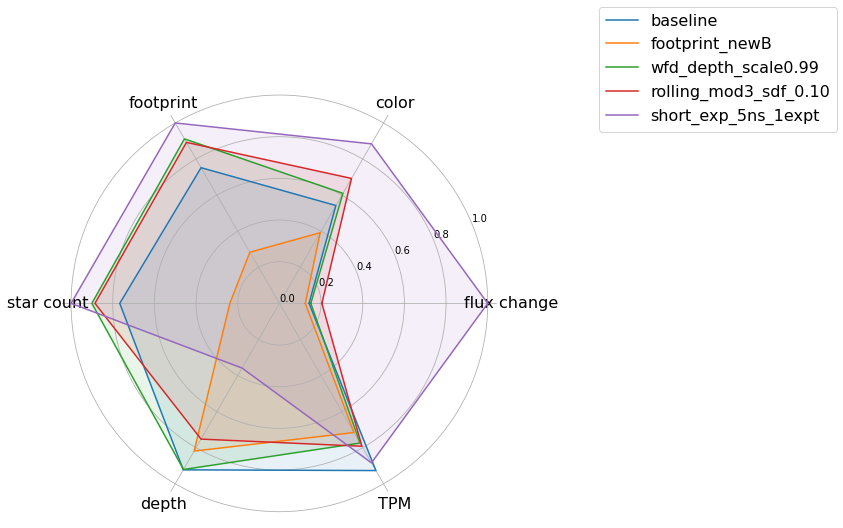

In [13]:
dbnames = [ 'baseline', 'footprint_newB',
           'wfd_depth_scale0.99','rolling_mod3_sdf_0.10',
           'short_exp_5ns_1expt']

FoMvars = ['flux change', 'color', 'footprint', 'star count', 'depth', 'TPM']


fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection': 'polar'} )

for dbname in dbnames:
    if 'v1.7'in dbname:
        r = df_norm_17[df_norm_17['db']=='baseline_nexp1_v1.7' ][FoMvars].values.flatten()
    else:
        r = df_rada[df_rada['db']==dbname ][FoMvars].values.flatten()
  
    ax = plot_radar(r=r, label=dbname, fill=True, ax=ax)

ax.set_xticklabels(FoMvars, );
ax.set_yticks([0, .2, .4, .6, .8, 1])
#ax.set_rlabel_position(0)
plt.rc('legend', fontsize=16) 
plt.rc('xtick',labelsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.2))